In [259]:
import math

def calculate_box_stats(data):
   # Sort list once for efficiency
    #data = [math.log(d) for d in data]
    sorted_data = sorted(data)
    n = len(sorted_data)
    
    # Calculate quartile positions
    q1_pos = n // 4
    q2_pos = n // 2
    q3_pos = (3 * n) // 4
   
    stats = {
       '最小值': sorted_data[0],
       '第一四分位數': sorted_data[q1_pos],
       '中位數': sorted_data[q2_pos] if n % 2 != 0 else (sorted_data[q2_pos-1] + sorted_data[q2_pos])/2,
       '第三四分位數': sorted_data[q3_pos],
       '最大值': sorted_data[-1],
       '平均': sum(sorted_data)/len(sorted_data),
       'test': sorted_data[-1] -  sum(sorted_data)/len(sorted_data)
    }
    
    return stats



In [260]:
import datasets
from datasets import load_dataset
from transformers import AutoTokenizer
from rouge_score import rouge_scorer
from bert_score import score as bert_scorer
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3.5-mini-instruct")

def convert_cnn_format(d):
    return {
        'id': d['id'],
        'text': d['article'],  # 或者如果要包含摘要：example['article'] + " " + example['highlights']
        'answer': d['highlights']
    }

def convert_human_eval_format(d):
    return {
        'id': d['task_id'],
        'text': d['prompt']
    }

def convert_qasper_format(d):
    texts = []
    answers = []
    for full_text in d['full_text']:
        doc = ""
        for paragraph in full_text["paragraphs"]:
            for sentence in paragraph:
                doc += sentence
                doc += "\n"
            doc += "  "
        texts.append(doc)
    i = 0
    for qas in d['qas']:
        answer = ""
        for ans in qas["answers"][0]["answer"]:
            answer = ans["free_form_answer"]
            if answer != "":
                break
        answers.append(answer)
        print("ans: ", answer)
    
        texts[i] = f"""
    Given the document, please answer the question.
    Doc:
    {texts[i]}

    Please answer the following question:
    {qas["question"][0]}
    """
        i += 1

    return {
        'id': d['id'],
        'text': texts,
        'answer': answers
    }

def load_cnn_sum() -> datasets.Dataset:
    ds = load_dataset("abisee/cnn_dailymail", "3.0.0", split='train+validation+test')
    ds = ds.map(
        convert_cnn_format,
        batched=True,
        remove_columns=['article', 'highlights']
    )
    return ds

def load_human_eval() -> datasets.Dataset:
    ds = load_dataset("openai_humaneval", split='test')
    ds = ds.map(
        convert_human_eval_format,
        batched=True
    )
    return ds


def convert_qsum_format(d):
    return {
        'id': d['id'],
        'text': d['input'],
        'answer': d['output']
    }

def load_qsum() -> datasets.Dataset:
    ds = load_dataset("pszemraj/qmsum-cleaned", split='train')
    ds = ds.filter(qsum_filter)
    ds = ds.map(convert_qsum_format, batched=True)
    return ds



def qsum_filter(d):
    prompt = tokenizer(d['input'], return_tensors="pt").input_ids
    return prompt.shape[1] < 5000

def qasper_filter(d): 
    qas = d["qas"]
    answer = ""
    for ans in qas["answers"][0]["answer"]:
        answer = ans["free_form_answer"]
        if answer != "":
            break
    return answer != ""


def load_qasper() -> datasets.Dataset:
    ds = load_dataset("allenai/qasper", split='train')
    ds = ds.filter( qasper_filter)
    print(ds)
    ds = ds.map(convert_qasper_format, batched=True)
    return ds


In [282]:
import json
from typing import List
import matplotlib.pyplot as plt

task_type = "QSUM"

match task_type:
    case "HUMAN_EVAL":
        ds = load_human_eval()
    case "SUM":
        ds = load_cnn_sum()
    case "QASPER":
        ds = load_qasper()
    case "QSUM":
        ds = load_qsum()


def calculate_avg_memory(path: str) -> List[float]:
    memory = []
    test = []
    scores = []
    token_lengths = []
    time = []
    mem_per_token = []
    input_len = []
    tok_per_sec = []
    model_memory = 0
    output_mem = []
    input_mem = []
    output_len = []
    mem = []
    i = 0
    with open(path, "r") as file:
        for line in file:
            data = json.loads(line.strip())
            if not "input_len" in data:
                continue
            t = data["time_metric"]
            time_taken = t[len(t) -1 ] - t[0]
            time.append(time_taken)
            tok_per_sec.append(data["output_len"] / time_taken)
            input_kv_memory = data["input_kv_memory"]
            memory_usage = data["memory_usage"]
            model_memory = 15284.85888
            output_len.append(data["output_len"])
            
            rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
            
            score = rouge.score(data["output"], ds[i]['answer'])['rougeL'].fmeasure
            #_, _, F1 = bert_scorer([data["output"]], [ds[i]['answer']], lang="en", verbose=True)
            
            scores.append(score)
            token_lengths.append(len(memory_usage))
            #differences = [usage for usage in memory_usage]
            differences = [usage for usage in memory_usage]
            differences.insert(0, model_memory)
            kv_memory = memory_usage[len(memory_usage)-1] - model_memory
            input_mem.append(memory_usage[0] - model_memory)
            output_mem.append(memory_usage[len(memory_usage)-1] - memory_usage[1])
            mem_per_token.append((max(memory_usage) - model_memory)/(data["output_len"] + data["input_len"]))
            input_len.append(data["input_len"])
            memory.append(differences)
            test.append(input_kv_memory-model_memory)
            i+= 1
            #test.append(differences)
    print("input", sum(input_mem)/len(input_mem))
    print("output", sum(output_mem)/len(output_mem))
    print("output len", sum(output_len) / len(output_len))
    print("model memory", model_memory)
    print("")
    longest = 0
    print("data count ", len(memory))
    #print(time)
    print("time", sum(time) / len(time))
    for r in memory:
        length = len(r)
        if longest < length:
            longest = length
    
    avg_mem = []

    token_lengths.sort()

    largest = token_lengths[int(len(memory)*0.9)]
    print(largest)

    usage = largest
    
    print("score: ", sum(scores) / len(scores))
    print("mem per token: ", sum(mem_per_token)/len(mem_per_token))
    print("token per sec: ", sum(tok_per_sec) / len(tok_per_sec))
    print("input_len: ", sum(input_len)/ len(input_len))
    for i in range(largest):
        total = 0
        count = 0
        for r in memory:
            if len(r) > i:
                total += r[i]
                count += 1
        avg_mem.append(total/count)
    w = avg_mem[:largest].copy()
    print(calculate_box_stats(w))
    return avg_mem

def plot(lines: List[List[float]]):


    # Plot each sublist as a separate line
    plt.figure(figsize=(10, 6))
    for idx, line in enumerate(lines):
        plt.plot(line, label=f'Line {idx+1}')

    # Adding labels, title, and legend
    plt.title('Line Graph of Multiple Lists')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()



In [277]:
import csv


def write_csvs(path, lst1, lst2):
    f = open(path, "w")
    writer = csv.writer(f)
    writer.writerow(["x", "y1", "y2"])
    w = list(range(len(lst1) + 1))
    w.pop(0)
    writer.writerows(zip(w,lst1, lst2))  # Data rows

def write_csv(path, lst):
    f = open(path, "w")
    writer = csv.writer(f)
    writer.writerow(["x", "y"])
    w = list(range(len(lst) + 1))
    w.pop(0)
    writer.writerows(zip(w,lst))  # Data rows

input 7145.886725688889
output 353.6893383111113
output len 452.77777777777777
model memory 15284.85888

data count  90
time 117.28792735205757
1001
score:  0.14574889445123698
mem per token:  1.5701743480010246
token per sec:  4.348823422950905
input_len:  4133.166666666667
{'最小值': 15284.858879999976, '第一四分位數': 19101.88279808, '中位數': 19790.254899199997, '第三四分位數': 20424.562266352936, '最大值': 22430.745605688895, '平均': 19782.36157111423, 'test': 2648.384034574665}


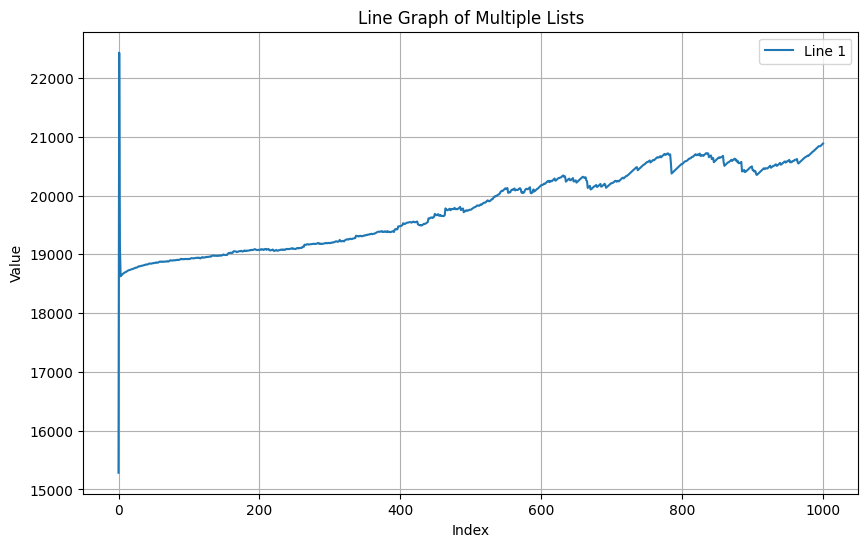

In [283]:
#origin_avg = calculate_avg_memory(f'/work/u4320956/tree_decoding/benchmark/out/origin/{task_type}/15_1000.jsonl')
tree_avg = calculate_avg_memory(f'/work/u4320956/tree_decoding/benchmark/out/tree/{task_type}/15_1000.jsonl')

#plot([origin_avg, tree_avg, ])
plot([tree_avg, ])
write_csv(f"15_{task_type}.csv", tree_avg)

input 59560.99436881013
output 2314.133536405063
output len 317.49367088607596
model memory 15284.85888

data count  79
time 139.20239198962344
468
score:  0.08612536000745288
mem per token:  13.215023561174757
token per sec:  2.3693621196052774
input_len:  4169.962025316456
{'最小值': 15284.85887999998, '第一四分位數': 45692.03980313924, '中位數': 46492.64031301907, '第三四分位數': 46988.573762782595, '最大值': 74845.85324881013, '平均': 46532.087491430364, 'test': 28313.76575737977}
input 7145.886520888889
output 0.9277553777774705
output len 429.05555555555554
model memory 15284.85888

data count  90
time 89.28999174435934
1001
score:  0.11195531827252443
mem per token:  1.5632978327742604
token per sec:  5.15304176513708
input_len:  4133.166666666667
{'最小值': 15284.858879999976, '第一四分位數': 18926.648905142858, '中位數': 19462.249910857143, '第三四分位數': 19748.040362666667, '最大值': 22430.745400888885, '平均': 19369.03256646624, 'test': 3061.712834422644}


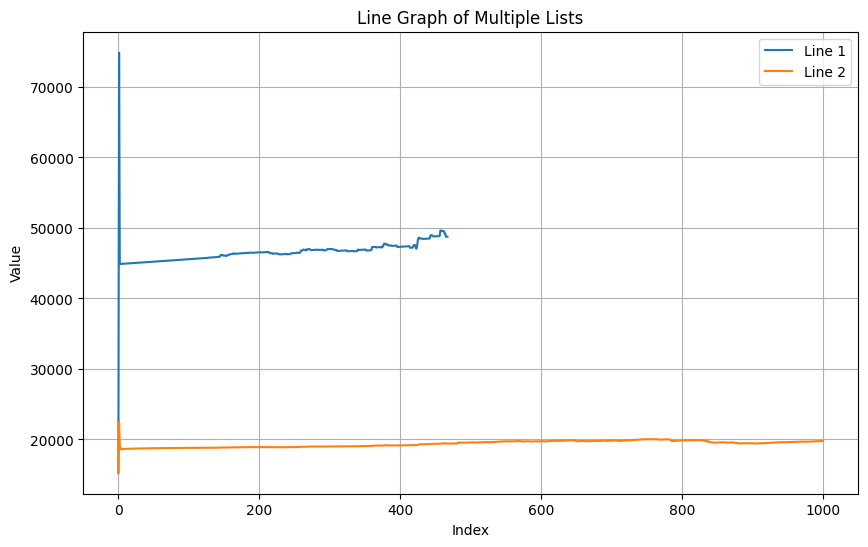

In [279]:
origin_avg = calculate_avg_memory(f'/work/u4320956/tree_decoding/benchmark/out/origin/{task_type}/9_1000.jsonl')
tree_avg = calculate_avg_memory(f'/work/u4320956/tree_decoding/benchmark/out/tree/{task_type}/9_1000.jsonl')

plot([origin_avg, tree_avg, ])
write_csvs(f"9_{task_type}.csv",origin_avg, tree_avg)

input 19874.716384000003
output 755.2533183999999
output len 314.6875
model memory 15284.85888

data count  80
time 68.56365173161029
462
score:  0.08532143099327368
mem per token:  4.416958565937548
token per sec:  4.669804466328427
input_len:  4165.4375
{'最小值': 15284.85887999998, '第一四分位數': 25445.0239168, '中位數': 25595.86428126315, '第三四分位數': 25764.784378553195, '最大值': 35159.57526400001, '平均': 25783.758167658274, 'test': 9375.817096341732}
input 7145.886429866668
output -167.4577578666666
output len 418.44444444444446
model memory 15284.85888

data count  90
time 68.2214005973604
1001
score:  0.09964143697812894
mem per token:  1.5666538686250555
token per sec:  6.306452053725359
input_len:  4133.166666666667
{'最小值': 15284.858879999976, '第一四分位數': 18768.5655808, '中位數': 19005.42641694118, '第三四分位數': 19172.307062153843, '最大值': 22430.745309866663, '平均': 18971.61277844823, 'test': 3459.1325314184323}


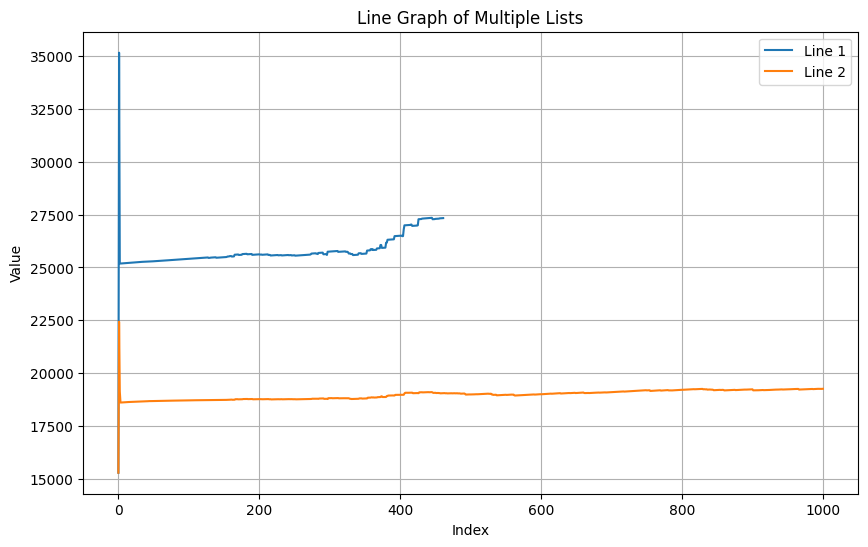

In [280]:
origin_avg = calculate_avg_memory(f'/work/u4320956/tree_decoding/benchmark/out/origin/{task_type}/3_1000.jsonl')
tree_avg = calculate_avg_memory(f'/work/u4320956/tree_decoding/benchmark/out/tree/{task_type}/3_1000.jsonl')

plot([origin_avg, tree_avg, ])
write_csvs(f"3_{task_type}.csv",origin_avg, tree_avg)

input 6615.832064
output 1033.823835022222
output len 303.9222222222222
model memory 15284.85888

data count  90
time 42.62398628923628
428
score:  0.0991837120970175
mem per token:  1.6796632649531407
token per sec:  7.1654890531918785
input_len:  4133.166666666667
{'最小值': 15284.858879999976, '第一四分位數': 18685.060858311117, '中位數': 19152.421346318843, '第三四分位數': 19773.16726153846, '最大值': 21900.690944000005, '平均': 19293.250609592596, 'test': 2607.440334407409}


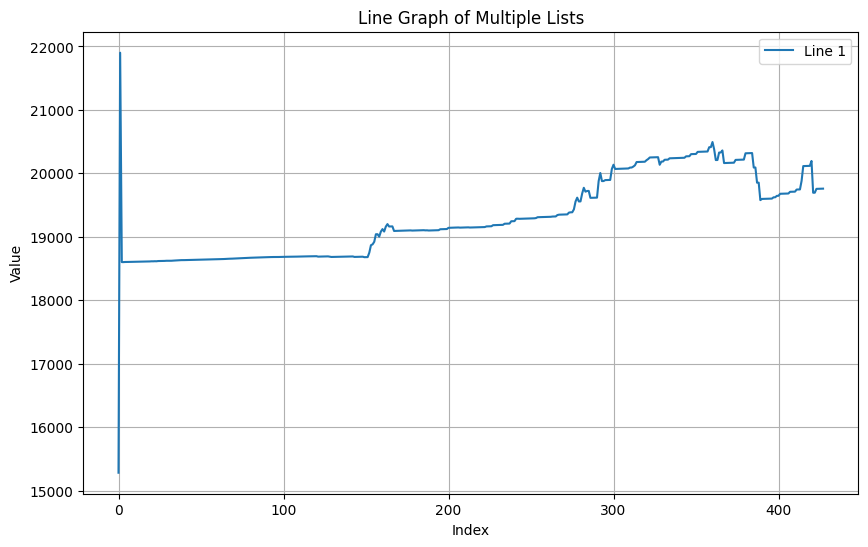

In [281]:
origin_avg = calculate_avg_memory(f'/work/u4320956/tree_decoding/benchmark/out/origin/{task_type}/1_1000.jsonl')
plot([origin_avg])
write_csv(f"1_{task_type}.csv",origin_avg)

In [1]:
import json
from typing import List
import matplotlib.pyplot as plt


def calculate_sequential(path: str) -> List[float]:
    memory = []
    test = []
    scores = []
    token_lengths = []
    time = []
    mem_per_token = []
    input_len = []
    tok_per_sec = []
    with open(path, "r") as file:
        for line in file:
            data = json.loads(line.strip())
            if not "input_len" in data:
                continue
            t = data["time_metric"]
            time_taken = t[len(t) -1 ] - t[0]
            time.append(time_taken)
            tok_per_sec.append(data["output_len"] / time_taken)
            input_kv_memory = data["input_kv_memory"]
            memory_usage = data["memory_usage"]
            model_memory = data["model_memory"]
            scores.append(data["score"])
            token_lengths.append(len(memory_usage))
            #differences = [usage for usage in memory_usage]
            differences = [usage - model_memory for usage in memory_usage]
            kv_memory = memory_usage[len(memory_usage)-1] - model_memory
            mem_per_token.append(kv_memory/(data["output_len"] + data["input_len"]))
            input_len.append(data["input_len"])
            memory.append(differences)
            test.append(input_kv_memory-model_memory)
            #test.append(differences)
    longest = 0
    print("data count ", len(memory))
    #print(time)
    print("time", sum(time) / len(time))
    for r in memory:
        length = len(r)
        if longest < length:
            longest = length
    
    avg_mem = []

    token_lengths.sort()

    largest = token_lengths[int(len(memory)*0.9)]
    print(largest)
    
    print("score: ", sum(scores) / len(scores))
    print("mem per token: ", sum(mem_per_token)/len(mem_per_token))
    print("token per sec: ", sum(tok_per_sec) / len(tok_per_sec))
    print("input_len: ", sum(input_len)/ len(input_len))
    for i in range(largest):
        total = 0
        count = 0
        for r in memory:
            if len(r) > i:
                total += r[i]
                count += 1
        avg_mem.append(total/count)
    return avg_mem

def plot(lines: List[List[float]]):


    # Plot each sublist as a separate line
    plt.figure(figsize=(10, 6))
    for idx, line in enumerate(lines):
        plt.plot(line, label=f'Line {idx+1}')

    # Adding labels, title, and legend
    plt.title('Line Graph of Multiple Lists')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

task_type = "HUMAN_EVAL"

data count  1
time 50.33566927909851
243
score:  0.0
mem per token:  10.556016597510373
token per sec:  1.6091968411282178
input_len:  160.0


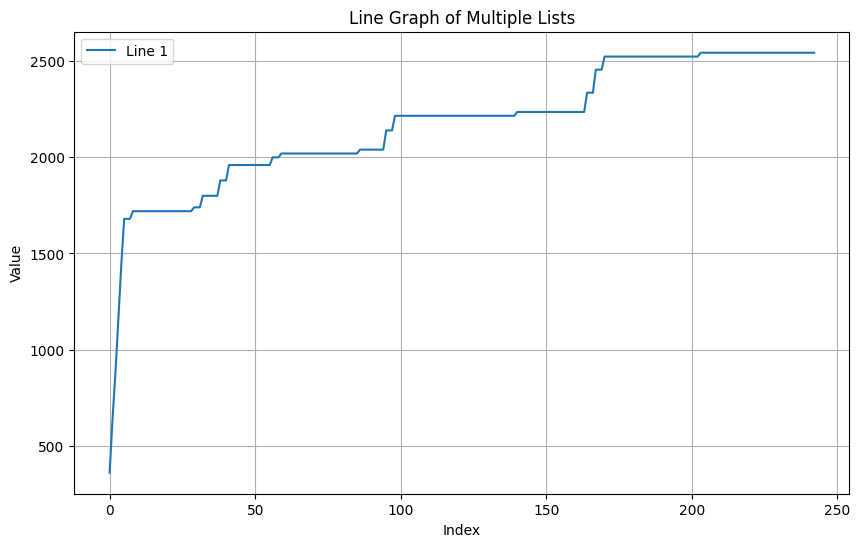

In [3]:
sequential = calculate_sequential(f'/work/u4320956/tree_decoding/benchmark/out/sequential/HUMAN_EVAL/3_1000.jsonl')

plot([sequential])